In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import json
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle
import tf_silent
from pinn import PINN
from network import Network
from optimizer_sep_losses import L_BFGS_B


2025-07-25 22:59:12.901346: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-25 22:59:12.952361: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-25 22:59:12.952418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-25 22:59:12.954211: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-25 22:59:12.963448: I tensorflow/core/platform/cpu_feature_guar

In [3]:
tf.config.list_logical_devices("GPU")

2025-07-25 22:59:15.107949: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-25 22:59:15.186344: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-25 22:59:15.187796: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

:localhost/replica:0/task:0/device:GPU:0 with 15012 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:1e:00.0, compute capability: 8.6


In [4]:
def mass_cons(network, xy):
    """
    Compute u_x and v_y
    Args:
        xy: network input variables as ndarray.
    Returns:
        (u_x, v_y) as ndarray.
    """

    xy = tf.constant(xy)
    x, y = [ xy[..., i, tf.newaxis] for i in range(xy.shape[-1]) ]
    with tf.GradientTape(persistent=True) as g:
      g.watch(x)
      g.watch(y)

      u_v_p = network(tf.concat([x, y], axis=-1))
      u = u_v_p[..., 0, tf.newaxis]
      v = u_v_p[..., 1, tf.newaxis]
      p = u_v_p[..., 2, tf.newaxis]
    u_x = g.batch_jacobian(u, x)[..., 0]
    v_y = g.batch_jacobian(v, y)[..., 0]

    return u_x.numpy(), v_y.numpy()


In [5]:
def u_0(xy):
    """
    Initial wave form.
    Args:
        tx: variables (t, x) as tf.Tensor.
    Returns:
        u(t, x) as tf.Tensor.
    """

    x = xy[..., 0, None]
    y = xy[..., 1, None]


    return    4*y*(1 - y) 


In [6]:

# number of training samples
num_train_samples = 4000
# number of test samples
num_test_samples = 400

# inlet flow velocity
u0 = 1
# density
rho = 1
# viscosity
mu = 2.5*1e-2
# Re = (L*u0*rho)/mu ==> rho/mu = 40

# Domain and circle data
x_f =2
x_ini=0
y_f=1
y_ini=0
Cx = 0.5
Cy = 0.5
a = 0.1
b = 0.1

In [7]:

xyt_circle = np.random.rand(num_train_samples, 2)
xyt_circle[...,0] = 2*(a)*xyt_circle[...,0] +(Cx-a)
xyt_circle[0:num_train_samples//2,1] = b*(1 - (xyt_circle[0:num_train_samples//2,0]-Cx)**2 / a**2)**0.5 + Cy
xyt_circle[num_train_samples//2:,1] = -b*(1 - (xyt_circle[num_train_samples//2:,0]-Cx)**2 / a**2)**0.5 + Cy

# create training input
xyt_eqn = np.random.rand(num_train_samples, 2)
xyt_eqn[...,0] = (x_f - x_ini)*xyt_eqn[...,0] + x_ini
xyt_eqn[...,1] = (y_f - y_ini)*xyt_eqn[...,1] + y_ini

corner_buffer = 0.05
max_attempts = 100

for i in range(num_train_samples):
    attempts = 0
    while True:
        inside_cylinder = (xyt_eqn[i, 0] - Cx)**2 / a**2 + (xyt_eqn[i, 1] - Cy)**2 / b**2 < 1
        near_corner = (
            (xyt_eqn[i, 0] < x_ini + corner_buffer and xyt_eqn[i, 1] < y_ini + corner_buffer) or
            (xyt_eqn[i, 0] < x_ini + corner_buffer and xyt_eqn[i, 1] > y_f - corner_buffer) or
            (xyt_eqn[i, 0] > x_f - corner_buffer and xyt_eqn[i, 1] < y_ini + corner_buffer) or
            (xyt_eqn[i, 0] > x_f - corner_buffer and xyt_eqn[i, 1] > y_f - corner_buffer)
        )

        if not (inside_cylinder or near_corner):
            break

        xyt_eqn[i, 0] = (x_f - x_ini) * np.random.rand() + x_ini
        xyt_eqn[i, 1] = (y_f - y_ini) * np.random.rand() + y_ini

        attempts += 1
        if attempts > max_attempts:
            print(f"Warning: Max attempts reached for sample {i}")
            break  # Accept the current (possibly imperfect) point or skip


In [8]:

# # Sample in the annulus (r+0.2) region # annulus is a plane region between two concentric circles
# num_annulus_samples = 1500
# theta = np.random.uniform(0, 2*np.pi, num_annulus_samples)
# r = np.sqrt(np.random.uniform(1, 9, num_annulus_samples))  # sqrt for uniform area
# # circle eqn in polar coordinates: x = Cx + a * r * cos(theta), y = Cy + b * r * sin(theta)
# x = Cx + a * r * np.cos(theta)
# y = Cy + b * r * np.sin(theta)
# xyt_annulus = np.stack([x, y], axis=1)

# # Wake region
# num_strip_samples = 2500
# x_strip = np.random.uniform(0.6, 1.2, num_strip_samples)
# y_strip = np.random.uniform(0.3, 0.7, num_strip_samples)
# xyt_strip = np.stack([x_strip, y_strip], axis=1)

# xyt_roi = np.concatenate([xyt_annulus, xyt_strip], axis=0)
# num_interior_samples = xyt_roi.shape[0]

xyt_w1 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
xyt_w1[..., 0] = (x_f - x_ini)*xyt_w1[...,0] + x_ini
xyt_w1[..., 1] =  y_ini          # y-position is 0 or 1
num_w1_samples = xyt_w1.shape[0]

xyt_w2 = np.random.rand(num_train_samples, 2)  # top-bottom boundaries
xyt_w2[..., 0] = (x_f - x_ini)*xyt_w2[...,0] + x_ini
xyt_w2[..., 1] =  y_f
num_w2_samples = xyt_w2.shape[0]

xyt_out = np.random.rand(num_train_samples, 2)  # left-right boundaries
xyt_out[..., 0] = x_f
num_out_samples = xyt_out.shape[0]

xyt_in = np.random.rand(num_train_samples, 2)
xyt_in[..., 0] = x_ini
num_in_samples = xyt_in.shape[0]

# Aggregate input data for training
x_train = [
    xyt_eqn,        # All interior points (PDE loss)
    # xyt_roi,  # Region of interest (annulus + strip)
    xyt_w1,            # Wall y=0
    xyt_w2,            # Wall y=1
    xyt_out,           # Outlet x=2
    xyt_in,            # Inlet x=0
    xyt_circle         # Cylinder boundary
]
# y_train: create outputs with respect to data shapes for each region
zeros_interior = np.zeros((xyt_eqn.shape[0], 3))
# zeros_roi = np.zeros((xyt_roi.shape[0], 3))
zeros_w1 = np.zeros((xyt_w1.shape[0], 3))
zeros_w2 = np.zeros((xyt_w2.shape[0], 3))
zeros_out = np.zeros((xyt_out.shape[0], 3))
zeros_circle = np.zeros((xyt_circle.shape[0], 3))

# Inlet boundary condition (update shape)
a = u_0(tf.constant(xyt_in)).numpy()
b = np.zeros((xyt_in.shape[0], 1))
onze = np.random.permutation(np.concatenate([a, b, a], axis=-1))

y_train = [
    zeros_interior,  # All interior points (PDE loss)
    # zeros_roi,       # Region of interest (annulus + strip)
    onze,            # Inlet x=0
    zeros_w1,        # Wall y=0
    zeros_w2,        # Wall y=1
    zeros_out,       # Outlet x=2
    zeros_circle     # Cylinder boundary
]

In [9]:
print("Training data shapes:")
print("Dimensions x: (x_cord, y_cord), y: (u, v, p)")
for x, y in zip(x_train, y_train):
    print(f"Shape of x: {x.shape}, Shape of y: {y.shape}")

Training data shapes:
Dimensions x: (x_cord, y_cord), y: (u, v, p)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)
Shape of x: (4000, 2), Shape of y: (4000, 3)


In [12]:
fixed_loss_weights = [1, 1, 1, 1, 1, 20]

# Define different architecture combinations
architecture_combinations = [
    # [layers, neurons_per_layer]
    [[20, 20], 'arch_2x20'],
    [[30, 30], 'arch_2x30'], 
    [[48, 48, 48, 48], 'arch_4x48'],
    [[64, 64, 64], 'arch_3x64'],
    [[100, 100], 'arch_2x100'],
    [[80, 80, 80, 80, 80], 'arch_5x80'],
    [[128, 64, 32], 'arch_pyramid_128_64_32'],
    [[50, 100, 100, 50], 'arch_diamond_50_100_100_50']
]


Training architecture #1: [20, 20] -> pinn_arch_2x20
Total parameters: 543
Optimizer: L-BFGS-B (maxiter=30000)


L-BFGS-B:  36%|███▌      | 10788/30000 [15:03<26:49, 11.94iter/s, loss=0.0443]


1/1 [==============================] - 0s 104ms/step
Model pinn_arch_2x20: Minimum u velocity in wake region = -0.0062


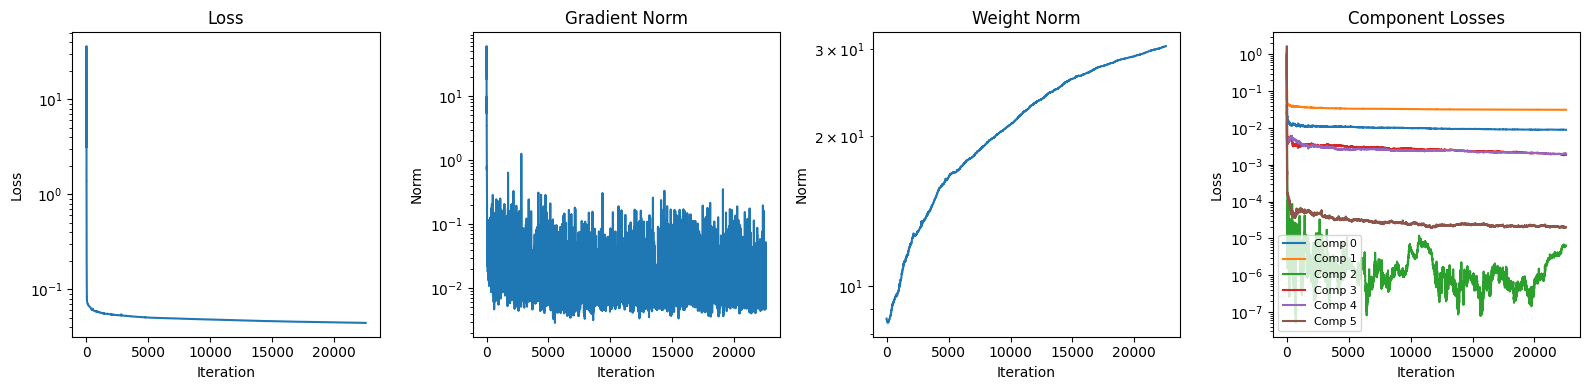


Training architecture #2: [30, 30] -> pinn_arch_2x30
Total parameters: 1113
Optimizer: L-BFGS-B (maxiter=30000)


L-BFGS-B:  46%|████▌     | 13766/30000 [19:29<22:59, 11.77iter/s, loss=0.0399] 


1/1 [==============================] - 0s 65ms/step
Model pinn_arch_2x30: Minimum u velocity in wake region = -0.0214


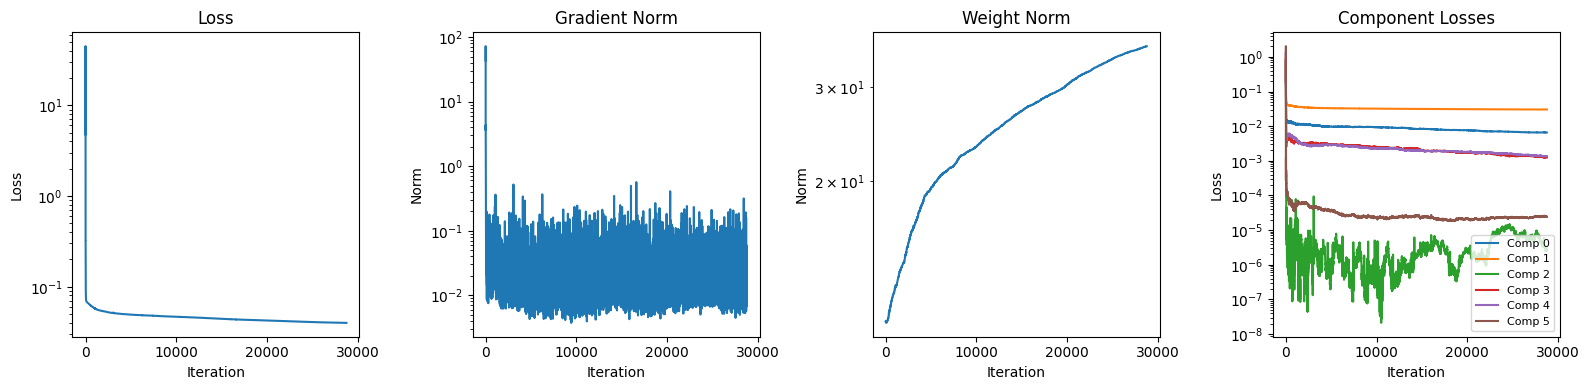


Training architecture #3: [48, 48, 48, 48] -> pinn_arch_4x48
Total parameters: 7347
Optimizer: L-BFGS-B (maxiter=30000)


L-BFGS-B:  31%|███       | 9300/30000 [17:52<39:46,  8.67iter/s, loss=0.0293]  

1/1 [==============================] - 0s 76ms/step


Model pinn_arch_4x48: Minimum u velocity in wake region = -0.0016


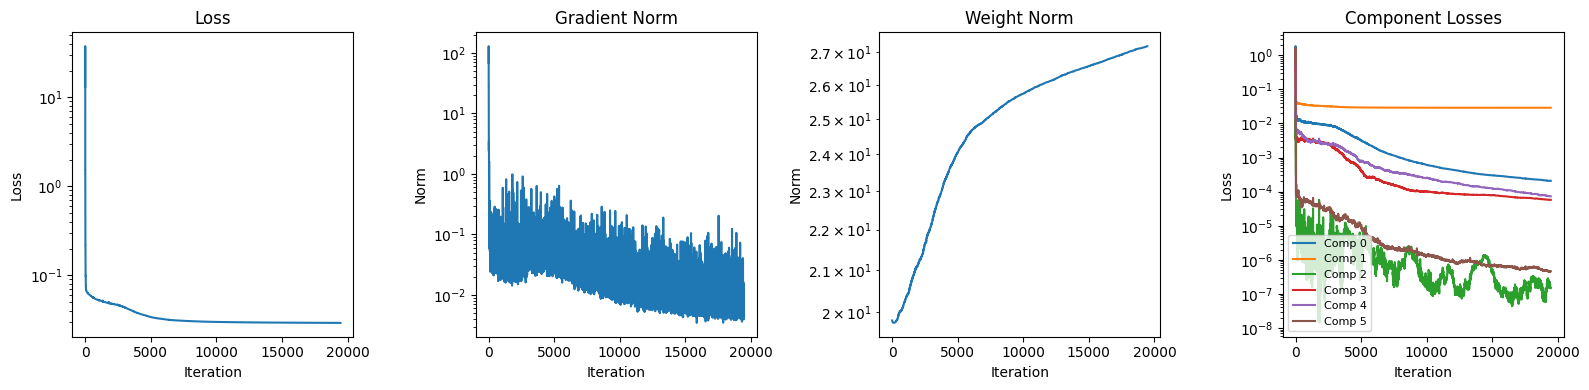


Training architecture #4: [64, 64, 64] -> pinn_arch_3x64
Total parameters: 8707
Optimizer: L-BFGS-B (maxiter=30000)


L-BFGS-B:  36%|███▌      | 10677/30000 [18:22<33:15,  9.68iter/s, loss=0.0293]

1/1 [==============================] - 0s 72ms/step


Model pinn_arch_3x64: Minimum u velocity in wake region = -0.0015


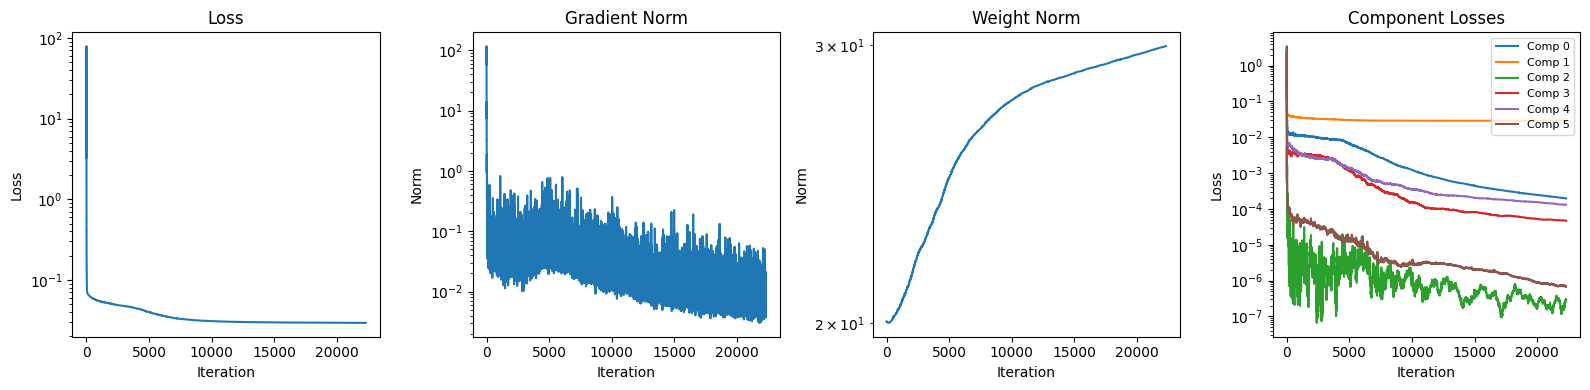


Training architecture #5: [100, 100] -> pinn_arch_2x100
Total parameters: 10703
Optimizer: L-BFGS-B (maxiter=30000)


L-BFGS-B:  13%|█▎        | 3831/30000 [39:20<4:28:46,  1.62iter/s, loss=0.0465]

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 68ms/step
Model pinn_arch_2x100: Minimum u velocity in wake region = -0.0099


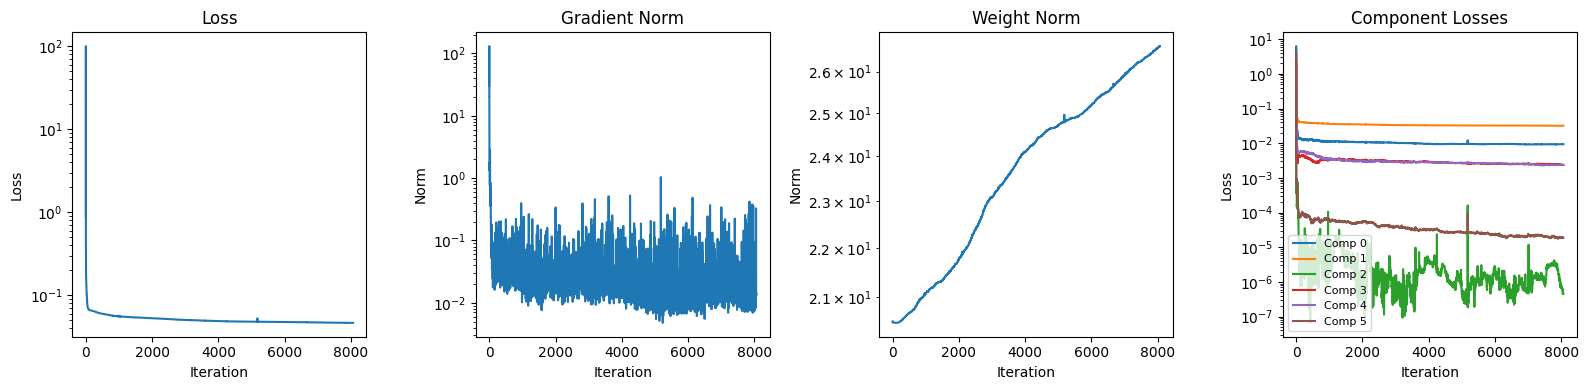


Training architecture #6: [80, 80, 80, 80, 80] -> pinn_arch_5x80
Total parameters: 26403
Optimizer: L-BFGS-B (maxiter=30000)


L-BFGS-B:  22%|██▏       | 6730/30000 [1:18:09<4:30:14,  1.44iter/s, loss=0.0291]


1/1 [==============================] - 0s 80ms/step
Model pinn_arch_5x80: Minimum u velocity in wake region = -0.0025


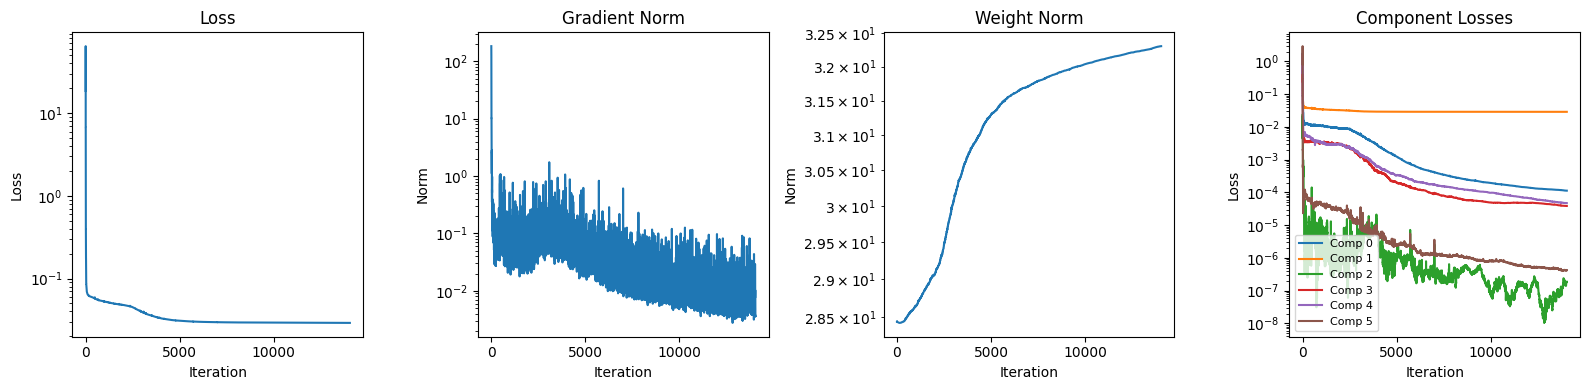


Training architecture #7: [128, 64, 32] -> pinn_arch_pyramid_128_64_32
Total parameters: 10819
Optimizer: L-BFGS-B (maxiter=30000)


L-BFGS-B:  41%|████      | 12222/30000 [2:10:02<3:09:09,  1.57iter/s, loss=0.0299]


1/1 [==============================] - 0s 69ms/step
Model pinn_arch_pyramid_128_64_32: Minimum u velocity in wake region = -0.0042


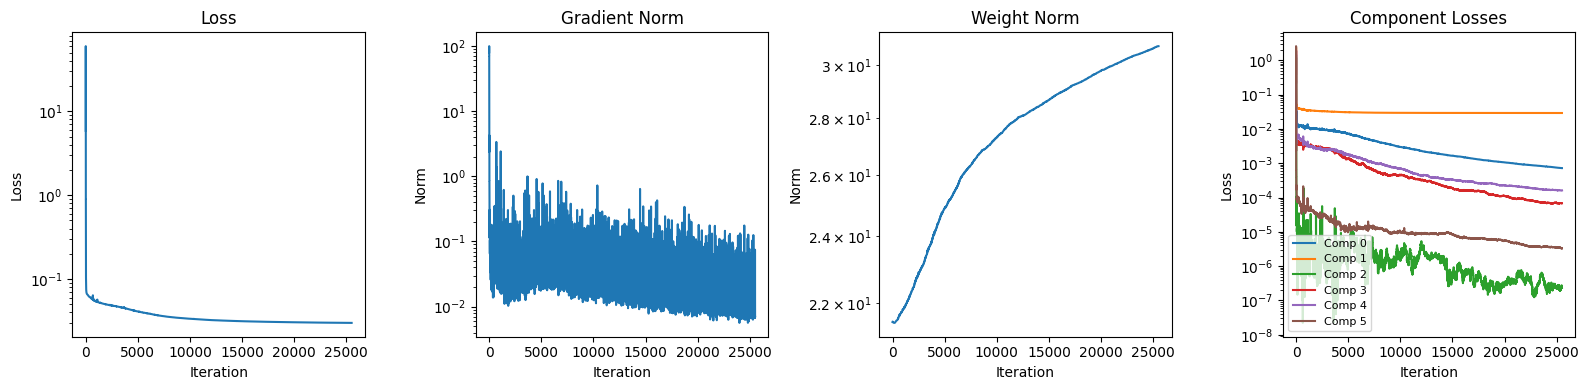


Training architecture #8: [50, 100, 100, 50] -> pinn_arch_diamond_50_100_100_50
Total parameters: 20553
Optimizer: L-BFGS-B (maxiter=30000)


L-BFGS-B:  37%|███▋      | 11071/30000 [2:04:45<3:33:19,  1.48iter/s, loss=0.0292]


1/1 [==============================] - 0s 85ms/step
Model pinn_arch_diamond_50_100_100_50: Minimum u velocity in wake region = -0.0038


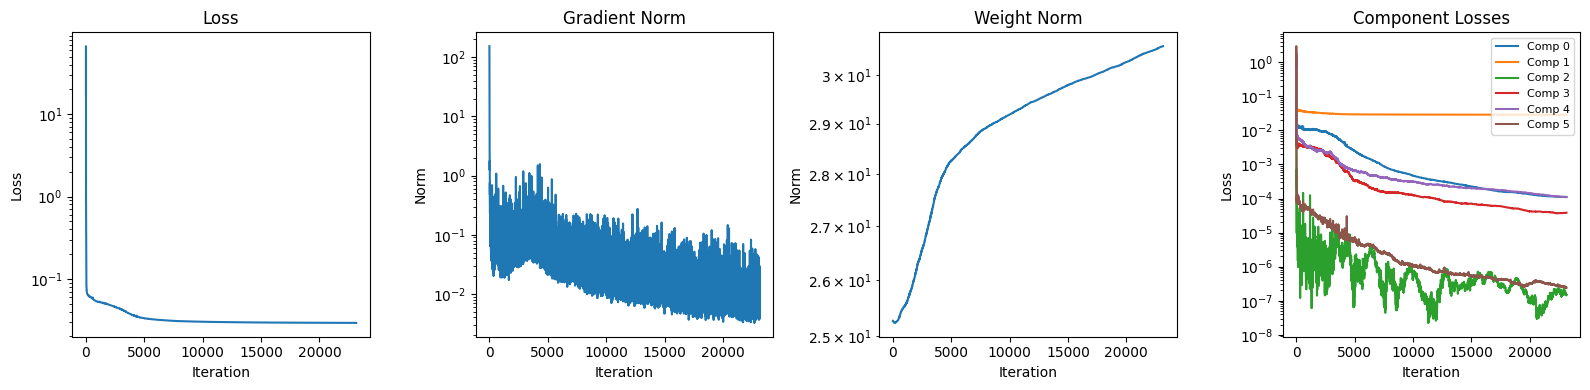


ARCHITECTURE STUDY RESULTS
Architecture: arch_2x20
  Layers: [20, 20]
  Parameters: 543
  Final Loss: 0.044330
  Min u wake: -0.0062
----------------------------------------
Architecture: arch_2x30
  Layers: [30, 30]
  Parameters: 1113
  Final Loss: 0.039893
  Min u wake: -0.0214
----------------------------------------
Architecture: arch_4x48
  Layers: [48, 48, 48, 48]
  Parameters: 7347
  Final Loss: 0.029271
  Min u wake: -0.0016
----------------------------------------
Architecture: arch_3x64
  Layers: [64, 64, 64]
  Parameters: 8707
  Final Loss: 0.029299
  Min u wake: -0.0015
----------------------------------------
Architecture: arch_2x100
  Layers: [100, 100]
  Parameters: 10703
  Final Loss: 0.046485
  Min u wake: -0.0099
----------------------------------------
Architecture: arch_5x80
  Layers: [80, 80, 80, 80, 80]
  Parameters: 26403
  Final Loss: 0.029081
  Min u wake: -0.0025
----------------------------------------
Architecture: arch_pyramid_128_64_32
  Layers: [128, 64,

In [13]:


# Define wake box region
a = 0.1  # radius of the cylinder
x_start = 0.5 + a  # 0.6
x_end = 1.2
y_start = 0.5 - 0.15  # 0.4
y_end = 0.5 + 0.15    # 0.6

model_dir = 'model_data/architecture_study'
os.makedirs(model_dir, exist_ok=True)
results = []


for i, (layers, arch_name) in enumerate(architecture_combinations):
    subdir = arch_name
    run_dir = os.path.join(model_dir, subdir)
    plot_dir = os.path.join(run_dir, 'plots')
    os.makedirs(plot_dir, exist_ok=True)

    model_name = f"pinn_{arch_name}"
    print(f"\nTraining architecture #{i+1}: {layers} -> {model_name}")

    # Reset network with new architecture and PINN model
    network = Network().build(layers=layers, activation='tanh')
    pinn = PINN(network, rho=rho, mu=mu).build()

    # Count total parameters
    total_params = network.count_params()
    print(f"Total parameters: {total_params}")

    # Setup optimizer
    lbfgs = L_BFGS_B(
        model=pinn,
        x_train=x_train,
        y_train=y_train,
        factr=1e5,
        m=50,
        maxls=50,
        maxiter=30000,
        loss_weights=fixed_loss_weights
    )

    # Train
    lbfgs.fit()

    # Save model
    model_path = os.path.join(run_dir, f'{model_name}.keras')
    network.save(model_path)

    # Save loss history
    np.save(os.path.join(run_dir, f'{model_name}_loss.npy'), np.array(lbfgs.tracker.losses))
    np.save(os.path.join(run_dir, f'{model_name}_component_losses.npy'), np.array(lbfgs.tracker.component_losses))

    final_loss = lbfgs.tracker.losses[-1] if lbfgs.tracker.losses else None

    font1 = {'family': 'serif', 'size': 20}

    # Inference mesh
    x = np.linspace(x_ini, x_f, 300)
    y = np.linspace(y_ini, y_f, 300)
    x_grid, y_grid = np.meshgrid(x, y)
    xy_flat = np.stack([x_grid.flatten(), y_grid.flatten()], axis=-1)

    # Predict (u, v, p)
    u_v_p = network.predict(xy_flat, batch_size=len(xy_flat))
    u = u_v_p[..., 0].reshape(x_grid.shape)
    v = u_v_p[..., 1].reshape(x_grid.shape)
    p = u_v_p[..., 2].reshape(x_grid.shape)

    # Create mask for points inside the wake box
    mask = (x_grid >= x_start) & (x_grid <= x_end) & (y_grid >= y_start) & (y_grid <= y_end)
    u_wake = u[mask]
    min_u_wake = np.min(u_wake)
    print(f"Model {model_name}: Minimum u velocity in wake region = {min_u_wake:.4f}")

    # Save u contour plot
    fig0, ax0 = plt.subplots(1, 1, figsize=(20, 8))
    cf0 = ax0.contourf(x_grid, y_grid, u, np.arange(-0.5, 1.1, .02), extend='both', cmap='rainbow')
    cbar0 = plt.colorbar(cf0)
    ax0.add_patch(Circle((0.5, 0.5), 0.1, color="black"))
    plt.title(f"{model_name}: u", fontdict=font1)
    plt.xlabel("x", fontdict=font1)
    plt.ylabel("y", fontdict=font1)
    plt.tick_params(axis='both', which='major', labelsize=15)
    cbar0.ax.tick_params(labelsize=15)
    plt.tight_layout()
    u_plot_path = os.path.join(plot_dir, f"{model_name}_u.png")
    plt.savefig(u_plot_path, dpi=300)
    plt.close()

    # Save v contour plot
    fig1, ax1 = plt.subplots(1, 1, figsize=(20, 8))
    cf1 = ax1.contourf(x_grid, y_grid, v, np.arange(-0.4, 0.4, .02), extend='both', cmap='rainbow')
    cbar1 = plt.colorbar(cf1)
    ax1.add_patch(Circle((0.5, 0.5), 0.1, color="black"))
    plt.title(f"{model_name}: v", fontdict=font1)
    plt.xlabel("x", fontdict=font1)
    plt.ylabel("y", fontdict=font1)
    plt.tick_params(axis='both', which='major', labelsize=15)
    cbar1.ax.tick_params(labelsize=15)
    plt.tight_layout()
    v_plot_path = os.path.join(plot_dir, f"{model_name}_v.png")
    plt.savefig(v_plot_path, dpi=300)
    plt.close()

    # Save pressure contour plot
    fig2, ax2 = plt.subplots(1, 1, figsize=(20, 8))
    cf2 = ax2.contourf(x_grid, y_grid, p, np.arange(-0.2, 1, .02), extend='both', cmap='rainbow')
    cbar2 = plt.colorbar(cf2)
    ax2.add_patch(Circle((0.5, 0.5), 0.1, color="black"))
    plt.title(f"{model_name}: p", fontdict=font1)
    plt.xlabel("x", fontdict=font1)
    plt.ylabel("y", fontdict=font1)
    plt.tick_params(axis='both', which='major', labelsize=15)
    cbar2.ax.tick_params(labelsize=15)
    plt.tight_layout()
    p_plot_path = os.path.join(plot_dir, f"{model_name}_p.png")
    plt.savefig(p_plot_path, dpi=300)
    plt.close()

    # Save streamlines plot
    fig3, ax3 = plt.subplots(1, 1, figsize=(20, 8))
    ax3.streamplot(x_grid, y_grid, u, v, color='k', density=5, linewidth=0.25)
    ax3.add_patch(Circle((0.5, 0.5), 0.1, color="black"))
    plt.title(f"{model_name}: Streamlines", fontdict=font1)
    plt.xlabel("x", fontdict=font1)
    plt.ylabel("y", fontdict=font1)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tight_layout()
    stream_plot_path = os.path.join(plot_dir, f"{model_name}_streamlines.png")
    plt.savefig(stream_plot_path, dpi=300)
    plt.close()

    # Plot optimization tracking
    lbfgs.plot_training()
    opt_plot_path = os.path.join(plot_dir, f"{model_name}_optimization.png")
    plt.savefig(opt_plot_path, dpi=300)
    plt.close()

    # Save a summary for this run
    summary_path = os.path.join(run_dir, f'{model_name}_training_summary.json')
    summary = {
        'architecture': layers,
        'architecture_name': arch_name,
        'total_parameters': int(total_params),
        'final_loss': float(final_loss) if final_loss is not None else None,
        'min_u_wake': float(min_u_wake),
        'model_filename': str(model_path),
        'u_plot': str(u_plot_path),
        'v_plot': str(v_plot_path),
        'p_plot': str(p_plot_path),
        'streamline_plot': str(stream_plot_path),
        'optimization_plot': str(opt_plot_path)
    }
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)

    results.append(summary)

# Save full summary for all architecture runs
with open(os.path.join(model_dir, 'all_architecture_summary.json'), 'w') as f:
    json.dump(results, f, indent=2)

# Print results summary
print("\n" + "="*60)
print("ARCHITECTURE STUDY RESULTS")
print("="*60)
for result in results:
    print(f"Architecture: {result['architecture_name']}")
    print(f"  Layers: {result['architecture']}")
    print(f"  Parameters: {result['total_parameters']}")
    print(f"  Final Loss: {result['final_loss']:.6f}")
    print(f"  Min u wake: {result['min_u_wake']:.4f}")
    print("-" * 40)

# Find best architecture by final loss
best_arch = min(results, key=lambda x: x['final_loss'] if x['final_loss'] is not None else float('inf'))
print(f"\nBest Architecture by Final Loss:")
print(f"  Name: {best_arch['architecture_name']}")
print(f"  Layers: {best_arch['architecture']}")
print(f"  Parameters: {best_arch['total_parameters']}")
print(f"  Final Loss: {best_arch['final_loss']:.6f}")
print(f"  Min u wake: {best_arch['min_u_wake']:.4f}")

# Find most parameter-efficient (best loss per parameter)
param_efficiency = [(r['final_loss'] / r['total_parameters'] * 1000, r) for r in results if r['final_loss'] is not None]
if param_efficiency:
    best_efficiency = min(param_efficiency, key=lambda x: x[0])
    best_eff_arch = best_efficiency[1]
    print(f"\nMost Parameter-Efficient Architecture:")
    print(f"  Name: {best_eff_arch['architecture_name']}")
    print(f"  Layers: {best_eff_arch['architecture']}")
    print(f"  Parameters: {best_eff_arch['total_parameters']}")
    print(f"  Final Loss: {best_eff_arch['final_loss']:.6f}")
    print(f"  Loss/1k params: {best_efficiency[0]:.6f}")

# Find architecture with strongest wake recirculation
strongest_wake_negative = min(results, key=lambda x: x['min_u_wake'])
print(f"\nArchitecture with Strongest Wake Recirculation:")
print(f"  Name: {strongest_wake_negative['architecture_name']}")
print(f"  Min u wake: {strongest_wake_negative['min_u_wake']:.4f}")

In [ ]:

# create meshgrid coordinates (x, y) for test plots    

x = np.linspace(x_ini, x_f, num_test_samples)
y = np.linspace(y_ini, y_f, num_test_samples)
x, y = np.meshgrid(x, y)
xy = np.stack([x.flatten(), y.flatten()], axis=-1)
# predict (psi, p)
u_v_p = network.predict(xy, batch_size=len(xy))
u, v, p = [ u_v_p[..., i].reshape(x.shape) for i in range(u_v_p.shape[-1]) ]
# compute (u, v)
u = u.reshape(x.shape)
v = v.reshape(x.shape)
p = p.reshape(x.shape)


In [ ]:
u.shape, v.shape, p.shape, x.shape, y.shape

In [ ]:

# # plot test results
# fig = plt.figure(figsize=(16, 8))
# contour(x, y, p, 'p')
# plt.tight_layout()
# plt.show()

# fig = plt.figure(figsize=(16, 8))
# contour(x, y, u, 'u')
# plt.tight_layout()
# plt.show()

# fig = plt.figure(figsize=(16, 8))
# contour(x, y, v, 'v')
# plt.tight_layout()
# plt.show()


###########################
from matplotlib.patches import Circle
font1 = {'family':'serif','size':20}

fig0, ax0 = plt.subplots(1, 1,figsize=(20,8))
cf0 = ax0.contourf(x, y, p, np.arange(-0.2, 1, .02),
                extend='both',cmap='rainbow')
cbar0 = plt.colorbar(cf0, pad=0.03, aspect=25, format='%.0e')
plt.title("p", fontdict = font1)
plt.xlabel("x", fontdict = font1)
plt.ylabel("y", fontdict = font1)
ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar0.ax.tick_params(labelsize=15)
plt.show()

###########################

fig0, ax0 = plt.subplots(1, 1, figsize=(20,8))
cf0 = ax0.contourf(x, y, u, np.arange(-0.5, 1.1, .02),
                extend='both',cmap='rainbow')
cbar0 = plt.colorbar(cf0, )
plt.title("u", fontdict = font1)
plt.xlabel("x", fontdict = font1)
plt.ylabel("y", fontdict = font1)
ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar0.ax.tick_params(labelsize=15)
plt.show()

###########################

fig0, ax0 = plt.subplots(1, 1,figsize=(20,8))
cf0 = ax0.contourf(x, y, v, np.arange(-0.4, 0.4, .02),
                extend='both',cmap='rainbow')
cbar0 = plt.colorbar(cf0, pad=0.03, aspect=25, format='%.0e')
plt.title("v", fontdict = font1)
plt.xlabel("x", fontdict = font1)
plt.ylabel("y", fontdict = font1)
ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar0.ax.tick_params(labelsize=15)
plt.show()

############################ 


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

font1 = {'family':'serif','size':20}

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
# Contourf for pressure (or any scalar field)
# cf = ax.contourf(x, y, u, np.arange(-0.2, 1, .02), extend='both', cmap='rainbow')
# cbar = plt.colorbar(cf, pad=0.03, aspect=25, format='%.0e')
# Streamlines for velocity field
strm = ax.streamplot(x, y, u, v, color='k', density=10, linewidth=0.25)
# Add cylinder
# ax.add_patch(Circle((0.5, 0.5), 0.1, color="black"))
plt.title("u with Streamlines (Re40)", fontdict=font1)
plt.xlabel("x", fontdict=font1)
plt.ylabel("y", fontdict=font1)
plt.tick_params(axis='both', which='major', labelsize=15)
# cbar.ax.tick_params(labelsize=15)
# plt.savefig('u_streamlinesonly_Re40_opd.png', dpi=300)
plt.show()

In [ ]:
# Plot velocity profiles along specified cross-sections
import pandas as pd
cross_sections = [
    ('x', 0.30),
    ('x', 0.35),
    ('x', 0.40),
    ('x', 0.45),
    ('x', 0.50),
    ('x', 0.55),
    ('x', 0.60),
    ('x', 0.61),
    ('x', 0.62),
    ('x', 0.63),
    ('x', 0.64),
    ('x', 0.65),
    ('x', 0.70),
    ('x', 0.75),
]
plot_profiles(x, y, u, v, cross_sections, save_csv=True, prefix="u40_opt", location="data/")


In [ ]:


import matplotlib.pyplot as plt
from matplotlib.patches import Circle

font1 = {'family':'serif','size':20}


fig, ax = plt.subplots(1, 1, figsize=(20, 8))
cf = ax.contourf(x, y, u, np.arange(-0.2, 1, .02), extend='both', cmap='rainbow')
cbar = plt.colorbar(cf, pad=0.03, aspect=25, format='%.0e')
# ax.plot([x.min(), x.max(), x.max(), x.min(), x.min()],
#         [y.min(), y.min(), y.max(), y.max(), y.min()],
#         color='black', linewidth=2, label='Domain Boundary')

ax.add_patch(Circle((0.5, 0.5), 0.1, color="black"))

# Overlay cross-section lines
for section in cross_sections:
    section_type, value = section
    if section_type == 'x':
        ax.axvline(value, color='red', linestyle='--', linewidth=2, label=f'x={value}')
    elif section_type == 'y':
        ax.axhline(value, color='blue', linestyle='--', linewidth=2, label=f'y={value}')

# Optional: avoid duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize=15)

plt.title("u with Cross-Sections(Re-40)", fontdict=font1)
plt.xlabel("x", fontdict=font1)
plt.ylabel("y", fontdict=font1)
plt.tick_params(axis='both', which='major', labelsize=15)
cbar.ax.tick_params(labelsize=15)
plt.savefig("u_with_cross_sections_40.png", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:

import pandas as pd

# ux_re10 = r"C:\Projects\SoftwareLab_SS25\Navier_Stokes_cylinder2D\data\Re10_Med_Ux\Re10_Med_Ux_0.75.csv"
ux_re100 = r"C:\Projects\SoftwareLab_SS25\Navier_Stokes_cylinder2D\data\Re100_Med_Ux\Re100_Med_Ux_0.75.csv"
# ux_re1000 = r"C:\Projects\SoftwareLab_SS25\Navier_Stokes_cylinder2D\data\Re1000_Med_Ux\Re1000_Med_Ux_0.75.csv"

# Read CSVs (assume columns: arc_length, U_X)
# df_re10 = pd.read_csv(ux_re10)
df_re100 = pd.read_csv(ux_re100)
# df_re1000 = pd.read_csv(ux_re1000)

# Plot OpenFOAM velocity profiles at x=0.75 for different Reynolds numbers
plt.figure(figsize=(8, 6))
# plt.plot(df_re10["arc_length"], df_re10["U_X"], label="OpenFOAM Re=10", color="green", marker="o")
plt.plot(df_re100["arc_length"], df_re100["U_X"], label="OpenFOAM Re=100", color="orange", marker="^")
# plt.plot(df_re1000["arc_length"], df_re1000["U_X"], label="OpenFOAM Re=1000", color="red", marker="s")
plt.xlabel("y (arc length)")
plt.ylabel("u (velocity x)")
plt.title("OpenFOAM Velocity Profiles at x = 0.75")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_profile_comparison(y_pinn, u_pinn, y_ref, u_ref, label_pinn="PINN", label_ref="OpenFOAM", title="Velocity Profile Comparison"):
    """
    Plot and compare two velocity profiles along the same cross-section.
    Args:
        y_pinn: y-coordinates for PINN data.
        u_pinn: velocity values for PINN data.
        y_ref: y-coordinates for reference data (e.g., OpenFOAM).
        u_ref: velocity values for reference data.
        label_pinn: label for PINN data.
        label_ref: label for reference data.
        title: plot title.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(y_pinn, u_pinn, label=label_pinn, color='blue')
    plt.plot(y_ref, u_ref, label=label_ref, color='orange')
    plt.xlabel('y (arc length)')
    plt.ylabel('u (velocity x)')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


# List of cross-sections of interest
cross_sections = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

for x_target in cross_sections:
    idx = np.argmin(np.abs(x[0, :] - x_target))
    y_pinn = y[:, idx]
    u_pinn = u[:, idx]
    # Load OpenFOAM reference data for this cross-section
    # Assumes file naming: data/Re10_cs/Re10_coarse_{x_target}.csv
    fname = f"data/Re40_coarse_cs/Re40_coarse_{x_target}.csv"
    try:
        df_re = pd.read_csv(fname)
        y_ref = df_re["arc_length"]
        u_ref = df_re["U_X"]
        plot_profile_comparison(
            y_pinn, u_pinn, y_ref, u_ref,
            label_pinn="PINN",
            label_ref="OpenFOAM",
            title=f"RE:40, u Profile at x={x_target}"
        )
    except FileNotFoundError:
        print(f"Reference file not found: {fname}")

In [ ]:
!pwd

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

cross_sections = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
fig, axes = plt.subplots(2, 5, figsize=(22, 8), sharey=True)
axes = axes.flatten()

for i, x_target in enumerate(cross_sections):
    idx = np.argmin(np.abs(x[0, :] - x_target))
    y_pinn = y[:, idx]
    u_pinn = u[:, idx]
    fname = f"../../data/Re40_coarse_cs/Re40_coarse_{x_target}.csv"
    try:
        df_re = pd.read_csv(fname)
        y_ref = df_re["arc_length"]
        u_ref = df_re["U_X"]
        axes[i].plot(y_pinn, u_pinn, label="PINN", color='blue')
        axes[i].plot(y_ref, u_ref, label="OpenFOAM", color='orange')
        axes[i].set_title(f"x={x_target}")
        axes[i].set_xlabel("y")
        if i % 5 == 0:
            axes[i].set_ylabel("u")
        axes[i].grid()
        if i == 0:
            axes[i].legend()
    except FileNotFoundError:
        axes[i].set_title(f"x={x_target}\nNo ref data")
        axes[i].set_xlabel("y")
        if i % 5 == 0:
            axes[i].set_ylabel("u")
        axes[i].grid()

plt.suptitle("Velocity Profile Comparison (PINN vs OpenFOAM)", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("profile_comparison_40.png", dpi=300)  # Save as high-res image
plt.show()

In [ ]:
import numpy as np
from scipy.interpolate import interp1d

# y_pinn, u_pinn: PINN y and u values at x=0.75
# y_ref, u_ref: OpenFOAM y and u values at x=0.75

# Interpolate PINN profile onto OpenFOAM's y-coordinates
u_pinn_interp = interp1d(y_pinn, u_pinn, kind='linear', bounds_error=False, fill_value='extrapolate')
u_pinn_on_ref = u_pinn_interp(y_ref)

# Compute errors
mae = np.mean(np.abs(u_pinn_on_ref - u_ref))
rmse = np.sqrt(np.mean((u_pinn_on_ref - u_ref)**2))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

In [ ]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

cross_sections = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]
results = []

for x_target in cross_sections:
    idx = np.argmin(np.abs(x[0, :] - x_target))
    y_pinn = y[:, idx]
    u_pinn = u[:, idx]
    fname = f"data/Re10_cs/Re10_coarse_{x_target}.csv"
    try:
        df_re = pd.read_csv(fname)
        y_ref = df_re["arc_length"]
        u_ref = df_re["U_X"]
        # Interpolate PINN profile onto OpenFOAM's y-coordinates
        u_pinn_interp = interp1d(y_pinn, u_pinn, kind='linear', bounds_error=False, fill_value='extrapolate')
        u_pinn_on_ref = u_pinn_interp(y_ref)
        # Compute errors
        mae = np.mean(np.abs(u_pinn_on_ref - u_ref))
        rmse = np.sqrt(np.mean((u_pinn_on_ref - u_ref)**2))
        results.append({'cs': x_target, 'mae': mae, 'rmse': rmse})
    except FileNotFoundError:
        results.append({'cs': x_target, 'mae': np.nan, 'rmse': np.nan})

# Create and display table
df_results = pd.DataFrame(results)
print(df_results)

In [ ]:
df_results.describe()

In [ ]:
df_results.to_csv("data/Re40_coarse_errors.csv", index=False)